In [ ]:
import tensorflow as tf
import cv2
import os
import numpy as np
import pickle

# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import zipfile

# 데이터셋 경로 설정
dataset_path = '/content/gdrive/MyDrive/archive.zip'
extract_path = '/content/dataset'

# 압축 파일 해제
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 압축 해제된 폴더 확인
!ls {extract_path}

real-life-violence-dataset  real-life-violence-dataset_newVersion


In [ ]:
dataset = '/content/dataset/real-life-violence-dataset/real-life-violence-dataset/dataset'
!ls {dataset}

NonViolence  Violence


# 데이터 전처리

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 크기 및 색상 채널 수 설정
IMG_SIZE = 224
ColorChannels = 3
batch_size = 32

# 학습 및 검증을 위한 데이터 생성기 생성
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_generator = train_datagen.flow_from_directory(
    directory=dataset,
    color_mode='rgb',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=True,  # 데이터를 섞으려면 True로 설정
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory=dataset,
    color_mode='rgb',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=False,  # 검증 데이터는 섞지 않음
    class_mode='categorical',
    subset='validation'
)


Found 26052 images belonging to 2 classes.
Found 8683 images belonging to 2 classes.


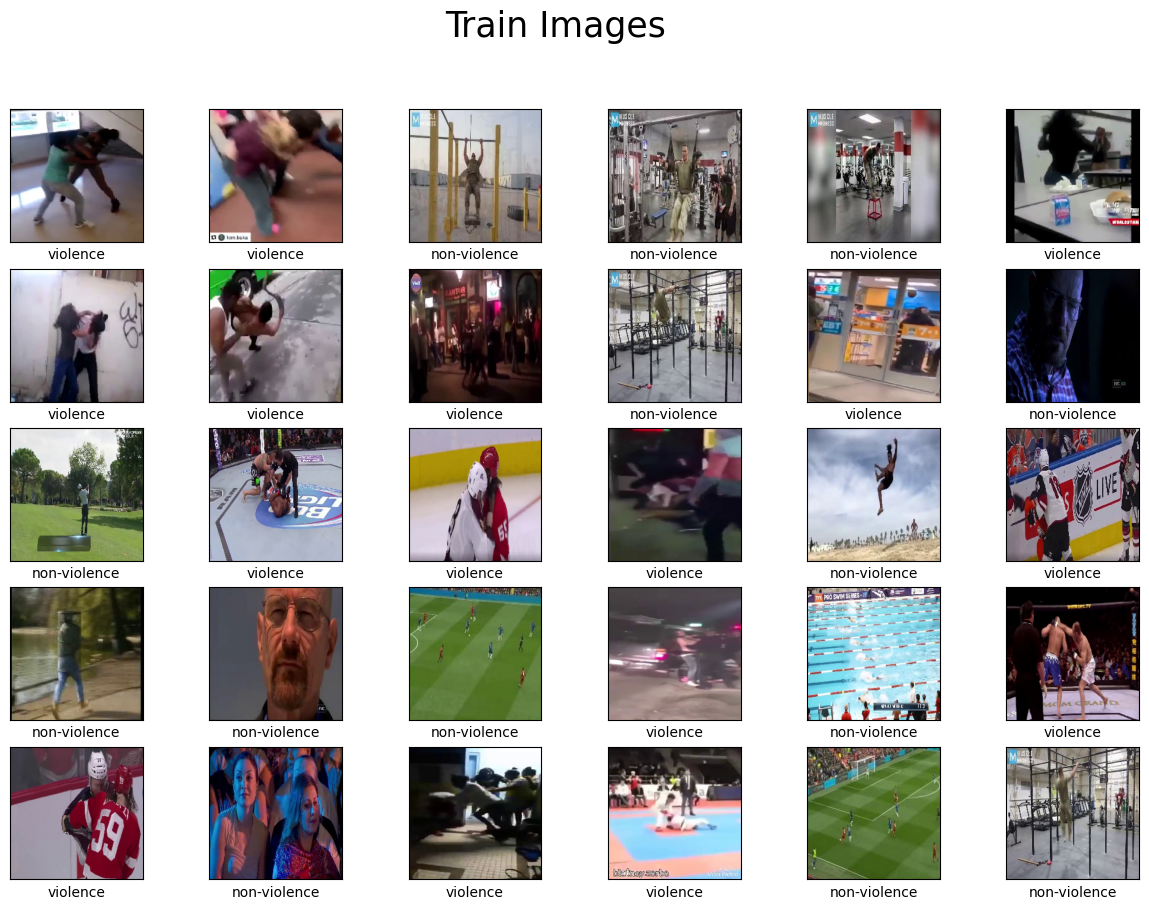

In [ ]:
import matplotlib.pyplot as plt

# 그래프 크기 설정 및 제목 추가
plt.figure(figsize=(15, 10))
plt.suptitle("Train Images", fontsize=25)

# 30개의 이미지를 시각화
for i in range(30):
    img, label = train_generator.next()
    plt.subplot(5, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if label[0][0] == 1:
        plt.xlabel("non-violence")
    else:
        plt.xlabel("violence")
    plt.imshow(img[0])

plt.show()

In [ ]:
!pip install imutils

In [ ]:
print(len(train_generator))
print(len(validation_generator))


815
272


# 모델 아키텍처 설계

In [ ]:
from keras import regularizers
from keras.optimizers import Adam
from keras.applications import ResNet152V2
from keras.layers import Input, Flatten, Reshape, LSTM, Dense, Dropout
from keras.models import Model

# 하이퍼파라미터 설정
epochs = 15
kernel_regularizer = regularizers.l2(0.0001)

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = ResNet152V2(include_top=False, weights='imagenet', input_tensor=input_tensor)

    headModel = baseModel.output
    headModel = Flatten()(headModel)
    headModel = Reshape((1, -1))(headModel)
    headModel = LSTM(128)(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.3)(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = Dense(2, activation="softmax")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    return model


In [ ]:
model=load_layers()

# 모델 학습 및 컴파일

In [ ]:
from tensorflow.keras.optimizers import Adam

# 옵티마이저 설정
optimizer = Adam(learning_rate=0.001)

# 모델 컴파일
model = load_layers()
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)


In [ ]:
# 모델 학습
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)


Epoch 1/15
815/815 [==============================] - 318s 368ms/step - loss: 0.1918 - accuracy: 0.9237 - val_loss: 0.1947 - val_accuracy: 0.9212
Epoch 2/15
815/815 [==============================] - 289s 355ms/step - loss: 0.1271 - accuracy: 0.9526 - val_loss: 0.2012 - val_accuracy: 0.9180
Epoch 3/15
815/815 [==============================] - 287s 352ms/step - loss: 0.1159 - accuracy: 0.9569 - val_loss: 0.1742 - val_accuracy: 0.9376
Epoch 4/15
815/815 [==============================] - 302s 371ms/step - loss: 0.1043 - accuracy: 0.9619 - val_loss: 0.2172 - val_accuracy: 0.9277
Epoch 5/15
815/815 [==============================] - 287s 352ms/step - loss: 0.0862 - accuracy: 0.9684 - val_loss: 0.1940 - val_accuracy: 0.9365
Epoch 6/15
815/815 [==============================] - 288s 353ms/step - loss: 0.0741 - accuracy: 0.9735 - val_loss: 0.2038 - val_accuracy: 0.9380
Epoch 7/15
815/815 [==============================] - 302s 370ms/step - loss: 0.0675 - accuracy: 0.9764 - val_loss: 0.1709 -

In [ ]:
!pip install seaborn

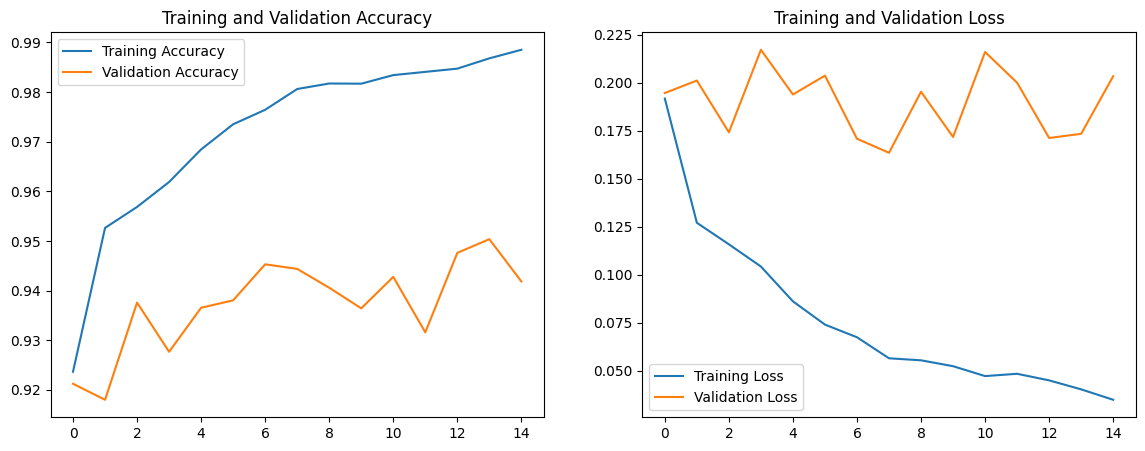

272/272 [==============================] - 77s 262ms/step
Classification Report
              precision    recall  f1-score   support

 NonViolence       0.96      0.91      0.94      3984
    Violence       0.93      0.97      0.95      4699

    accuracy                           0.94      8683
   macro avg       0.94      0.94      0.94      8683
weighted avg       0.94      0.94      0.94      8683

Confusion Matrix


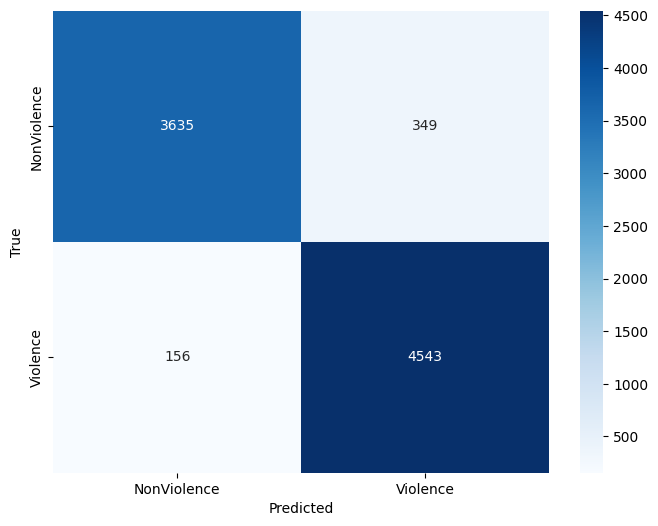

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 학습 및 검증 정확도 및 손실 그래프 그리기
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# 성능 지표 계산 및 출력
def print_performance_metrics(model, validation_generator):
    validation_generator.reset()
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    print('Classification Report')
    print(classification_report(validation_generator.classes, y_pred, target_names=validation_generator.class_indices.keys()))

    print('Confusion Matrix')
    conf_matrix = confusion_matrix(validation_generator.classes, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 학습 및 검증 정확도 및 손실 그래프
plot_history(history)

# 성능 지표 출력
print_performance_metrics(model, validation_generator)

In [ ]:
model.save('/content/gdrive/MyDrive/violence_model.h5')

# 실제 훈련 데이터 결과와 테스트 데이터 결과 비교

In [ ]:
test_path = '/content/dataset/real-life-violence-dataset/real-life-violence-dataset/test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 테스트 데이터 생성기 생성
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    color_mode='rgb',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4606 images belonging to 2 classes.


In [ ]:
model.evaluate(test_generator)

144/144 [==============================] - 38s 263ms/step - loss: 0.2141 - accuracy: 0.9420


[0.21408303081989288, 0.9420321583747864]

1/1 [==============================] - 0s 46ms/step


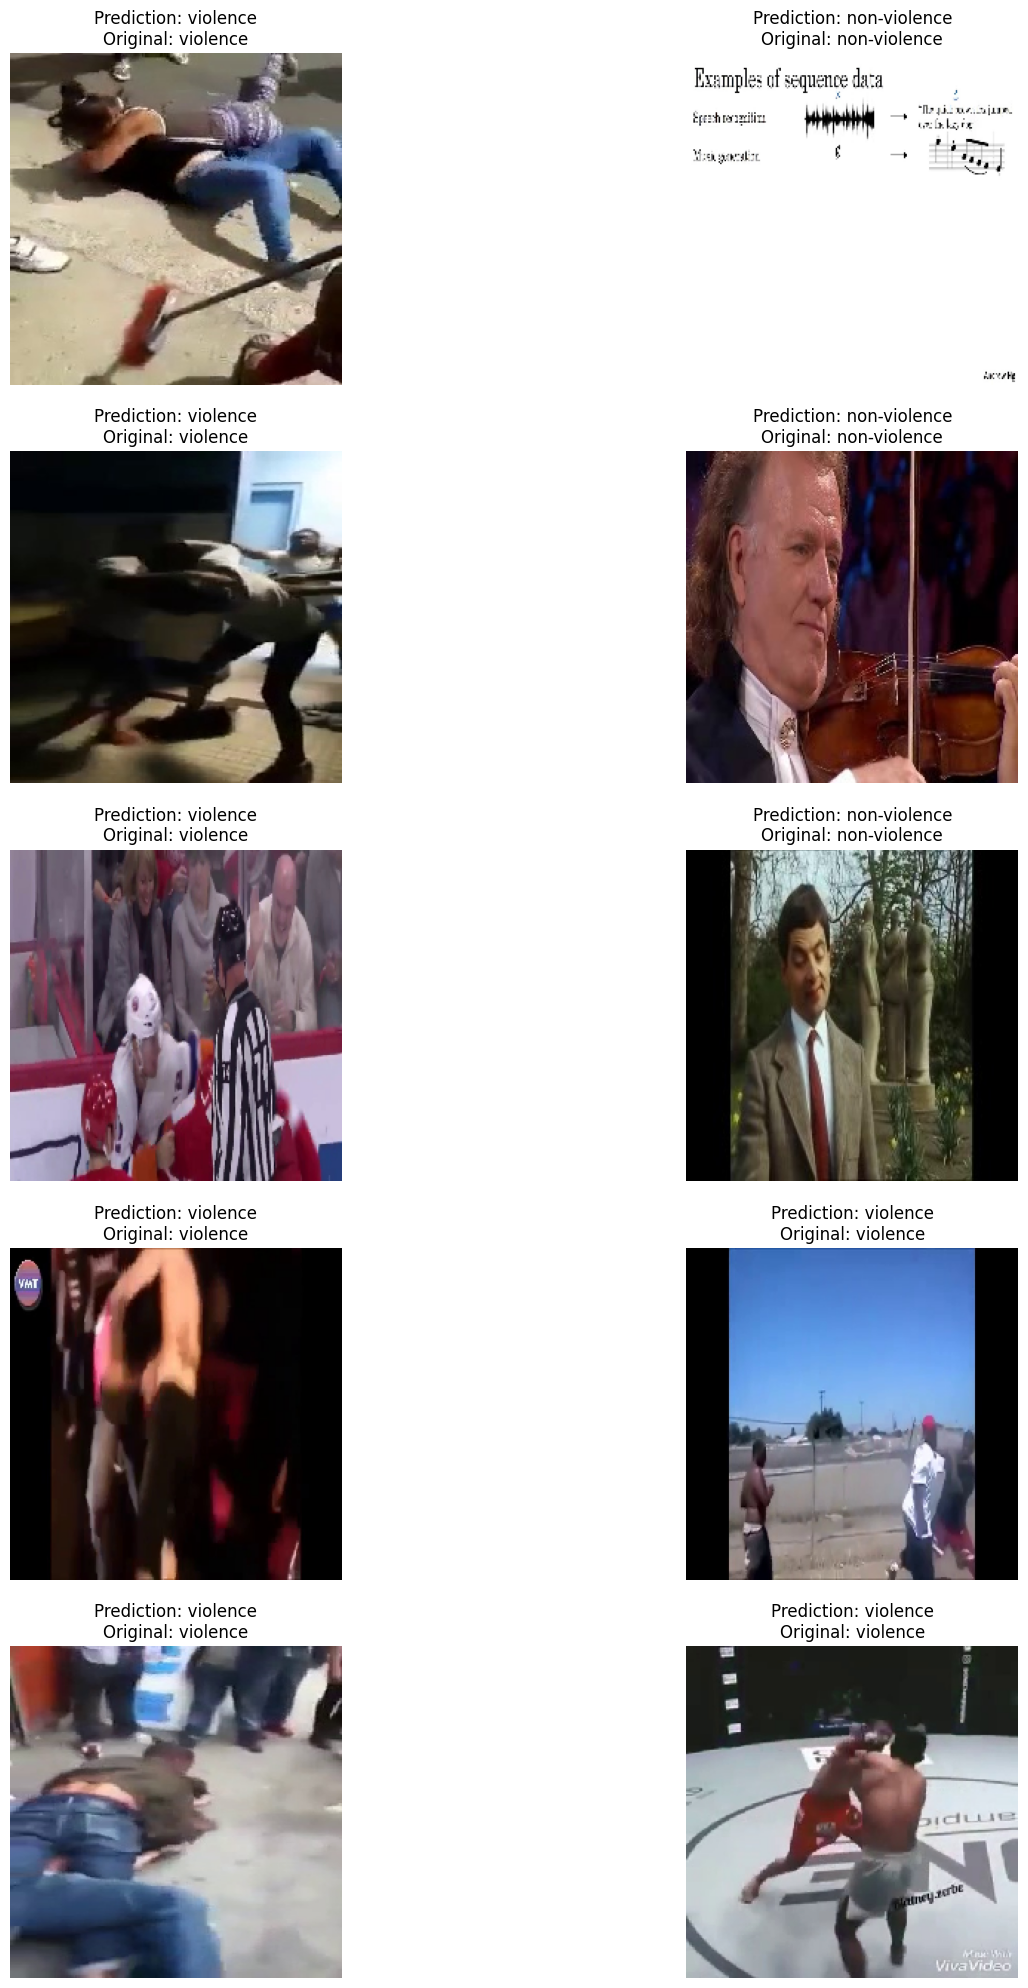

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# 10개의 이미지를 비교하여 시각화
plt.figure(figsize=(16, 25))
class_label = ['non-violence', 'violence']

# 테스트 데이터에서 10개의 이미지 가져오기
image, label = test_generator.next()
for i in range(10):
    model_pred = model.predict(image)
    plt.subplot(5, 2, i+1)
    plt.imshow(image[i])
    predicted_label = class_label[tf.argmax(model_pred[i]).numpy()]
    true_label = class_label[tf.argmax(label[i]).numpy()]
    plt.title(f"Prediction: {predicted_label}\nOriginal: {true_label}")
    plt.axis("off")
plt.show()
